# PREM

In order to calculate the pressure and acceleation due to gravity within the core, we make
use of the Preliminary Reference Earth Model (PREM) due to Dziewonski and Anderson (1981).
Our implementation of this model is contained in the files `earth_model.py` and `peice_poly.py`
and is flexible and mostly analytical. This notebook shows the standard implementation for the 
calculation of pressure. Furether notebooks showing other uses of these modules
can be found at [https://github.com/andreww/prem4derg](https://github.com/andreww/prem4derg).

### References

Dziewonski, A. M., and D. L. Anderson. ‘Preliminary Reference Earth Model’. Physics of the Earth 
and Planetary Interiors 25 (1981): 297–356.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

%matplotlib inline 

In [2]:
import earth_model

## PREM's density parameterisation

In PREM, density is described by a set of peicewise polynomials. These allow us to 
calculate the acceleation due to gravity and pressure within the Earth. Our `earth_model`
implementation of PREM is mostly analytical and allows flexible specification of the
density coefficents.

$$
\rho(r) = \left\{
\begin{array}{ll}
      \rho_{0,0} + \rho_{0,1}r + \rho_{0,2}r^2 + \rho_{0,3}r^3 & r\leq 1221.5 \; \mathrm{km} \\
      \rho_{1,0} + \rho_{1,1}r + \rho_{1,2}r^2 + \rho_{1,3}r^3 & 1221.5\leq r\leq 3480.0 \; \mathrm{km}\\
      \vdots & \vdots \\
      \rho_{12,0} + \rho_{12,1}r + \rho_{12,2}r^2 + \rho_{12,3}r^3 & 6368.0\leq r\leq 6371.0 \; \mathrm{km} \\
\end{array} 
\right.
$$

In [3]:
# This implements the PREM density model. Also found in the earth_model PREM object. 

r_earth = 6371 # km

density_params = np.array([[13.0885,  0.0000, -8.8381,  0.0000],
                           [12.5815, -1.2638, -3.6426, -5.5281],
                           [7.9565, -6.4761,  5.5283, -3.0807],
                           [7.9565, -6.4761,  5.5283, -3.0807],
                           [7.9565, -6.4761,  5.5283, -3.0807],
                           [5.3197, -1.4836,  0.0000,  0.0000],
                           [11.2494, -8.0298,  0.0000,  0.0000],
                           [7.1089, -3.8045,  0.00002,  0.0000],
                           [2.6910,  0.6924,  0.0000,  0.0000],
                           [2.6910,  0.6924,  0.0000,  0.0000],
                           [2.9000,  0.0000,  0.0000,  0.0000],
                           [2.6000,  0.0000,  0.0000,  0.0000],
                           [1.0200,  0.0000,  0.0000,  0.0000]])


# Turn range of polynomials from 0 - 1 to 0 - r_earth (makes mass easer)
# and puts density into kg/m^3
density_params[:,0] = density_params[:,0] * 1000
density_params[:,1] = (density_params[:,1] * 1000) / r_earth 
density_params[:,2] = (density_params[:,2] * 1000) / (r_earth**2)
density_params[:,3] = (density_params[:,3] * 1000) / (r_earth**3)


# All 14 discontiuities in PREM in km.
breakpoints = np.array([0.0, 1221.5, 3480.0, 3630.0, 5600.0, 5701.0, 5771.0,
                        5971.0, 6151.0, 6291.0, 6346.6, 6356.0, 6368.0, 6371.0])



prem = earth_model.Prem(breakpoints=breakpoints, density_params=density_params, 
                        r_earth=r_earth)

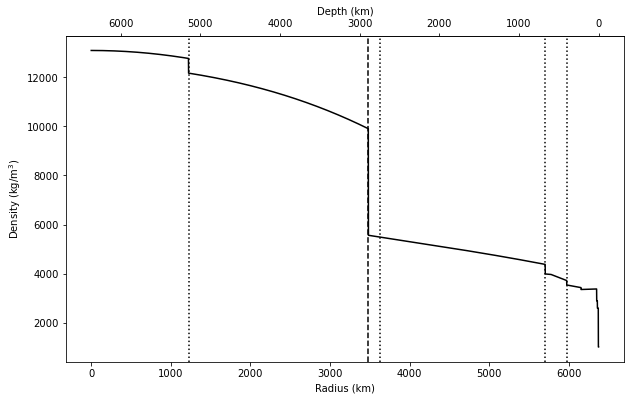

In [4]:
# What does it look like?
fig, ax = plt.subplots(figsize=(10,6))

rs = np.arange(0, 6371, 0.5)
ax.plot(rs, prem.density(rs), 'k')

ax.set_xlabel('Radius (km)')
ax.set_ylabel('Density (kg/m$^3$)')

ax.axvline(1221.5, ls=':', c='k')
ax.axvline(3480, ls='--', c='k')
ax.axvline(3630, ls=':', c='k')
ax.axvline(5701, ls=':', c='k')
ax.axvline(5971, ls=':', c='k')

secax = ax.secondary_xaxis('top', functions=(lambda x: 6371 - x, lambda x: 6371 - x))
secax.set_xlabel('Depth (km)')


plt.show()

## Mass and moment of inertia

The mass within the Earth is given by:

$$ M = 4\pi \int_0^{R_{e}} \rho(r) r^2 \,\mathrm{d}r.$$

And the moment of inertia by:

$$I = \frac{2}{3} 4\pi \int_0^{R_{e}} \rho(r) r^4 \,\mathrm{d}r.$$

Mass of the Earth is: 5.973178452676284e+24 kg
Earth's moment of inertia is:  4.86761046310148e+37 kg m^2
I/MR**2: 0.2007682881618122


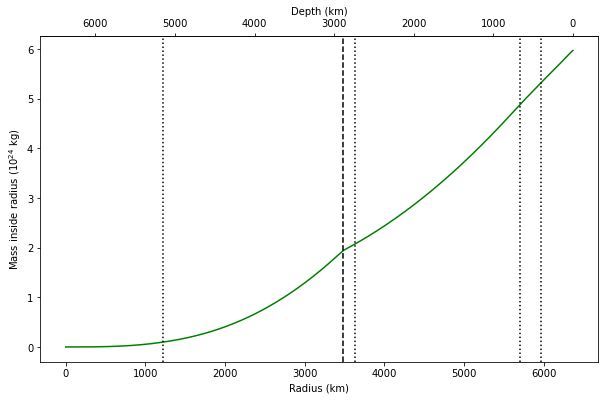

In [5]:
print("Mass of the Earth is:", prem.mass(prem.r_earth), "kg")
print("Earth's moment of inertia is: ", prem.moment_or_inertia(prem.r_earth)[0], "kg m^2")
print("I/MR**2:", prem.moment_or_inertia(prem.r_earth)[1])

# What does it look like?
fig, ax = plt.subplots(figsize=(10,6))

rs = np.arange(0, 6371, 0.5)
ax.plot(rs, prem.mass(rs)/1e24, 'g')

ax.set_xlabel('Radius (km)')
ax.set_ylabel('Mass inside radius ($10^{24}$ kg)')

ax.axvline(1221.5, ls=':', c='k')
ax.axvline(3480, ls='--', c='k')
ax.axvline(3630, ls=':', c='k')
ax.axvline(5701, ls=':', c='k')
ax.axvline(5971, ls=':', c='k')

secax = ax.secondary_xaxis('top', functions=(lambda x: 6371 - x, lambda x: 6371 - x))
secax.set_xlabel('Depth (km)')

plt.show()

## Gravity and pressure

The acceleration due to gravity at some radius is determined by the mass within that radius:

$$ M(r) = 4\pi \int_0^{r} \rho(r^{\prime}) r^{\prime 2} \,\mathrm{d}r^{\prime}.$$

$$g(r) = \frac{G M(r)}{r^2} $$

and the pressure is determined by hydrostatic equilibrium:

$$P(r) = \int_{R_e}^r -g(r^{\prime}) \rho(r^{\prime}) \,\mathrm{d}r^{\prime} $$

This final integral is implemented numerically.

Surface gravity: 9.821911198154554 m/s^2
Pressure at center of Earth: 364.04388866461255 GPa
Pressure at CMB: 135.8145751053026 GPa


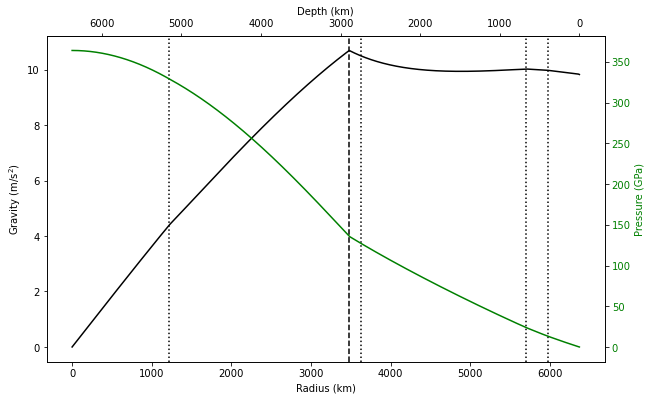

In [6]:
print("Surface gravity:", prem.gravity(6371), "m/s^2")
print("Pressure at center of Earth:", prem.pressure(0.0), "GPa")
print("Pressure at CMB:", prem.pressure(3480.0), "GPa")

# What does it look like?
fig, ax = plt.subplots(figsize=(10,6))

rs = np.arange(0, 6371, 0.5)
ax.plot(rs, prem.gravity(rs), 'k')

ax.set_xlabel('Radius (km)')
ax.set_ylabel('Gravity (m/s$^2$)')

ax2 = ax.twinx() 
ax2.plot(rs, prem.pressure(rs), 'g')
ax2.set_ylabel('Pressure (GPa)', color='g')
ax2.tick_params(axis='y', labelcolor='g')


ax.axvline(1221.5, ls=':', c='k')
ax.axvline(3480, ls='--', c='k')
ax.axvline(3630, ls=':', c='k')
ax.axvline(5701, ls=':', c='k')
ax.axvline(5971, ls=':', c='k')

secax = ax.secondary_xaxis('top', functions=(lambda x: 6371 - x, lambda x: 6371 - x))
secax.set_xlabel('Depth (km)')

plt.show()